# Flats Web Scraping

After attempting various **web scraping techniques**, automating screen-by-screen navigation through the user interface, and extracting data from the webpage's front-end (using libraries such as Selenium), we have decided that the most optimal and quickest method is to **retrieve the data directly from the communication between the front-end and the back-end. This is achieved by directly accessing the file passed from the back-end to the front-end of the webpage for its corresponding visualization**.

To do this, **we need the link to this file, and we will retrieve its content using the 'requests' library.**

In [4]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from tqdm import tqdm

In [5]:
pd.set_option('display.max_columns', None)

## Scraping directly from back-end request

Basically, we will obtain **two types of files** (with two types of url):

- File containing a **list of flats**: Each one contains a list of 30 flats on that screen and their general information, including the **apartment ID**.
- File containing **detailed information of the flat**: Given the ID of the previous apartments, we can obtain the URL of each apartment and scrape all its information.

In [17]:
# File containing a list of flats
url = "https://web.gw.fotocasa.es/v2/propertysearch/search?combinedLocationIds=724,9,8,232,376,8019,0,0,0&culture=es-ES&includePurchaseTypeFacets=true&isMap=false&isNewConstructionPromotions=false&latitude=41.3854&longitude=2.17754&pageNumber=2&platformId=1&propertyTypeId=2&sortOrderDesc=true&sortType=scoring&transactionTypeId=1"
headers = {
    'authority': 'www.google.com',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'max-age=0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36',
}

response = requests.get(url, headers=headers)
data = response.json()
page_ids = [data["realEstates"][i]["id"] for i in range(0,len(data["realEstates"]))]

print(f"{len(page_ids)} Flats. First 5 IDs:",page_ids[0:5])

30 Flats. First 5 IDs: [181204442, 181660975, 179469252, 182570237, 182570236]


In [35]:
# File containing detailed information of the flat
url = f"https://web.gw.fotocasa.es/v2/propertysearch/property?culture=es-ES&locale=es-ES&transactionType=1&periodicityId=0&id={page_ids[12]}"
response = requests.get(url, headers=headers)
data = response.json()
print("Flat Value:", f'{data["transactions"][0]["value"][0]}€', )

Flat Value: 420500€


In [36]:
def get_num_multi_dict(multi_data):
    num_multi = {}
    for multi in multi_data:
        try: num_multi[f'multimedia_type_{multi["typeId"]}'] += 1
        except: num_multi[f'multimedia_type_{multi["typeId"]}'] = 1
    return num_multi


## Scraping all pages

Knowing the number of pages (with 30 flats each), we have developed a code prepared to **navigate through each page and flat, prepared to handle possible errors and various request restrictions**, and **store all the information of each flat for later retrieval and analysis**.

Usually, **when we process many consecutive pages, the server blocks our access for a while**. There are different methods to deal with this. We can program to **change the UserAgent when this happens, or change the IP address periodically** so that the server doesn't detect the massive scraping. I have tried these methods, and **it is also useful to wait for a while and then rerun the code from the page where we left off**.

Even though there should be 14310 flats (477 pages * 30 flats per page), we've only managed to **extract approximately 9000 unique flats**. It's more probable that the 477 page count isn't accurate, in order to exaggerate the available inventory, rather than an issue with our scraping process.

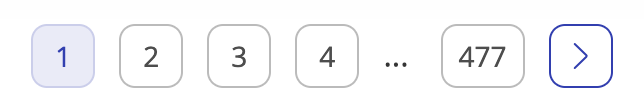

In [41]:
from IPython.display import Image
Image("media/pages_scrapping.png")

In [42]:
init_page = 0
final_page = 1


In [43]:
id_list = []
type_list = []
subtype_list = []
is_external_contract_list = []
is_invalid_list = []
is_new_list = []
advertiser_name_list = []
num_multi_list = []
descriptions_esp_list = []
descriptions_eng_list = []
features_list = []
features2_list = [] 
features3_list = [] 
num_transacions_list = []
trans_type_id_list = []
value_list = []
reduced_list = []
periodicity_id_list = []

ubication_list = []
location_list = []
coordinates_list = []
zipcode_list = []
highlight_list = []
date_list = []

energy_letter_list = []
energy_value_list = []
environment_letter_list = []
environment_value_list = []

headers = {
    'authority': 'www.google.com',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-language': 'en-US,en;q-=0.9',
    'cache-control': 'max-age=0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36',
    }

for i in tqdm(range(init_page, final_page)):
    
    url = f"https://web.gw.fotocasa.es/v2/propertysearch/search?combinedLocationIds=724,9,8,232,376,8019,0,0,0&culture=es-ES&includePurchaseTypeFacets=true&isMap=false&isNewConstructionPromotions=false&latitude=41.3854&longitude=2.17754&pageNumber={i}&platformId=1&propertyTypeId=2&sortOrderDesc=true&sortType=scoring&transactionTypeId=1"
    
    try:
        response = requests.get(url, headers=headers)
        data_ids = response.json()
        page_ids = [data_ids["realEstates"][i]["id"] for i in range(0,len(data_ids["realEstates"]))]
    except:
        print(f"Error trying to get response or generating json in page {i}")
        continue
        
    for id in page_ids:
        url = f"https://web.gw.fotocasa.es/v2/propertysearch/property?culture=es-ES&locale=es-ES&transactionType=1&periodicityId=0&id={id}"
        try:
            response = requests.get(url, headers=headers)
        except:
            print(f"Error trying to reach the response by requests.get(url) in ID {id}")

        if response.status_code == 403:
            print(f"Error in request for ID {id} and I {i}. Status code: {response.status_code}")
            break
        
        try:
            data = response.json()
        except Exception as e:
            print(f"Error parsing JSON for ID {id}: {e}")
            continue
        
        try:
            # Basic Data
            id_val = data["id"]
            type_val = data["typeId"]
            subtype_val = data["subtypeId"]
            is_external_contract_val = data["isExternalContact"]
            is_invalid_val = data["isInvalid"]
            is_new_val = data["isNew"]
            advertiser_name_val = data["advertiser"]["name"]
            num_multi_val = get_num_multi_dict(data["multimedias"])
            descriptions_esp_val = data["descriptions"]["es-ES"]
        
            # Features and Characteristics
            features_dict = {list(data["features"][i].keys())[0]:list(data["features"][i].values())[0] for i in range(0,len(data["features"]))}
            features2_dict = {data["featuresList"][i]["label"]:data["featuresList"][i]["value"] for i in range(0,len(data["featuresList"]))}
            features3_dict = {list(data["otherFeatures"][i].keys())[0]:list(data["otherFeatures"][i].values())[0] for i in range(0,len(data["otherFeatures"]))}
            features3_swap_dict = {v:k for k,v in features3_dict.items()}
        
            # Price Data
            num_transactions = len(data["transactions"])
            trans_type_id_val = data["transactions"][0]["transactionTypeId"]
            value_val = data["transactions"][0]["value"][0]
            reduced_val = data["transactions"][0]["reduced"]
            periodicity_id_val = data["transactions"][0]["periodicityId"]
            
            # Ubication
            ubication_val = data["address"]["ubication"]
            location_val = data["address"]["location"]
            coordinates_val = data["address"]["coordinates"]
            zipcode_val = data["address"]["zipCode"]
        
            # Additional data
            highlight_val = data["highlight"]
            date_val = data["date"]
            energy_letter_val = data["propertyEnergyCertificate"]["energyEfficiencyRatingTypeId"]
            energy_value_val = data["propertyEnergyCertificate"]["energyEfficiencyValue"]
            environment_letter_val = data["propertyEnergyCertificate"]["environmentImpactRatingTypeId"]
            environment_value_val = data["propertyEnergyCertificate"]["environmentImpactValue"]
        
        except:
            print("Error reading features.")
            continue

        id_list.append(id_val)
        type_list.append(type_val)
        subtype_list.append(subtype_val)
        is_external_contract_list.append(is_external_contract_val)
        is_invalid_list.append(is_invalid_val)
        is_new_list.append(is_new_val)
        advertiser_name_list.append(advertiser_name_val)
        num_multi_list.append(num_multi_val)
        descriptions_esp_list.append(descriptions_esp_val)
        features_list.append(features_dict)    
        features2_list.append(features2_dict)
        features3_list.append(features3_swap_dict)
        num_transacions_list.append(num_transactions)
        trans_type_id_list.append(trans_type_id_val)
        value_list.append(value_val)
        reduced_list.append(reduced_val)
        periodicity_id_list.append(periodicity_id_val)
        ubication_list.append(ubication_val)
        location_list.append(location_val)
        coordinates_list.append(coordinates_val)
        zipcode_list.append(zipcode_val)
        highlight_list.append(highlight_val)
        date_list.append(date_val)
        energy_letter_list.append(energy_letter_val)
        energy_value_list.append(energy_value_val)
        environment_letter_list.append(environment_letter_val)
        environment_value_list.append(environment_value_val)
        
        time.sleep(2)


100%|█████████████████████████████████████████████| 1/1 [01:06<00:00, 66.98s/it]


In [51]:
# Number of extracted flats
expected_len = (final_page-init_page)*30
print("Extracted flats:", len(value_list), "Expected:", expected_len, f"{(len(value_list)/expected_len)*100}%")


Extracted flats: 30 Expected: 30 100.0%


In [49]:
# Create DataFrames and Join all Scraped Data
df_basics = pd.DataFrame({"id":id_list, "type":type_list, "subtype":subtype_list, "external_contract":is_external_contract_list, "invalid":is_invalid_list, "new":is_new_list, "advertiser":advertiser_name_list, "description":descriptions_esp_list,
                   "transactions":num_transacions_list, "transaction_type":trans_type_id_list, "value":value_list, "reduced":reduced_list, "periodicity_id":periodicity_id_list,
                   "ubication": ubication_list, "zipcode": zipcode_list,
                   "highlight":highlight_list, "date":date_list, "energy_letter":energy_letter_list, "energy_value":energy_value_list, "environment_letter":environment_letter_list, "environment_value":environment_value_list})


df_from_dicts = pd.concat([pd.DataFrame(num_multi_list),
                           pd.DataFrame(features_list),
                           pd.DataFrame(features2_list),
                           pd.DataFrame(features3_list),
                           pd.DataFrame(location_list),
                           pd.DataFrame(coordinates_list),
                          ],axis=1)

df = pd.concat([df_basics, df_from_dicts], axis=1)

In [48]:
# Save DataFrame
# df.to_csv(f"data{init_page}_{final_page}.csv", index=False)